In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import astropy
from astropy.wcs import WCS
from astropy.io import fits
import h5py

import torch
import torchvision.utils as vutils

from torchsummary_ import summary
from helper_functions import *
import models
import networks
import train

In [ ]:
importlib.reload(networks)
importlib.reload(models)
importlib.reload(train)

**Options**

In [2]:
model_opt, train_opt = train.get_opts([])

Options:
Namespace(D_levels=5, D_pred=1, G_levels=6, beta1=0.5, distD='L1', distG='L1', input_nc=1, lambda_DL=50, lambda_GL=0.5, lossD_weight=0.5, lr=0.001, ndf=128, netD_name='Multi', netG_name='cGAN', ngf=64, ngpu=0, norm_type='spectralD', numeric_features=13, nz=128, output_nc=1, sampling_mode=1, size=64)
Namespace(batch_size=8, dataset_noise=0.0001, draw_dist='./labels/HDF5_F4_s64_k4-10_unique_norm6.pkl', image_freq=2500, limit_len_test=None, limit_len_train=None, load_iter=None, load_name=None, num_epochs=8, num_workers=0, print_freq=1250, save_dir='./runs/', save_freq=10000, save_num=3, test_batch_size=128, test_freq=2500, test_path='./data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_test.h5', train_path='./data/VISTA_cutouts/HDF5_F4_s64_k4-10_unique_norm6_train.h5')


**StarsCutoutDataset**

In [3]:
train_dataloader, test_dataloader = train.get_dataloaders(model_opt, train_opt)

Initializing datasets and dataloaders... Done.
Training set: 80000 cutouts, batch size: 8
Testing set: 6502 cutouts, batch size: 128


In [4]:
fixed_label_noise = train.make_fixed_label_noise(model_opt.numeric_features, model_opt.nz, 64, train_opt.draw_dist)

In [5]:
real_batch = next(iter(train_dataloader))
real_batch[0].shape, real_batch[1].shape, real_batch[2].shape

(torch.Size([8, 1, 64, 64]), torch.Size([8, 13]), torch.Size([8, 128]))

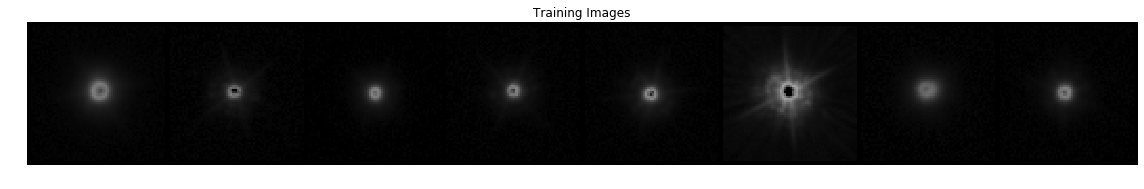

In [6]:
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(make_grid_transpose(real_batch[0]))
plt.tight_layout()
plt.show()

(array([100.,  99., 104., 102., 103., 105., 112.,  97., 105.,  97.]),
 array([-9.9958032e-01, -7.9985231e-01, -6.0012430e-01, -4.0039626e-01,
        -2.0066823e-01, -9.4020367e-04,  1.9878782e-01,  3.9851585e-01,
         5.9824389e-01,  7.9797190e-01,  9.9769992e-01], dtype=float32),
 <a list of 10 Patch objects>)

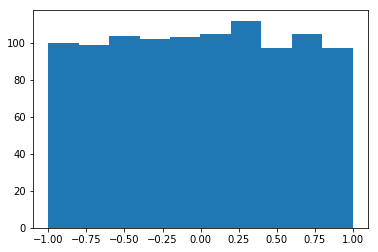

In [7]:
plt.hist(real_batch[2].flatten())

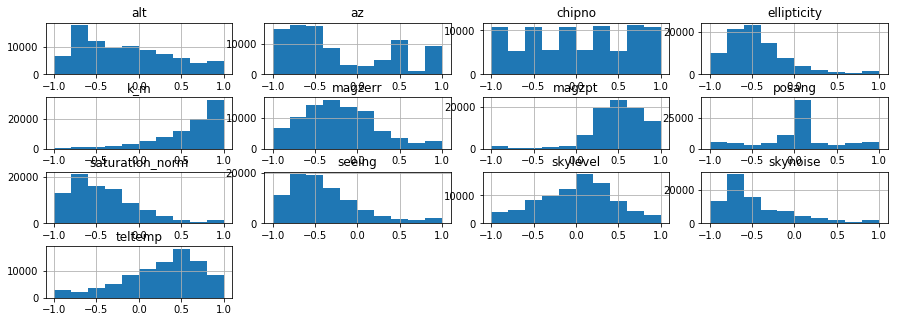

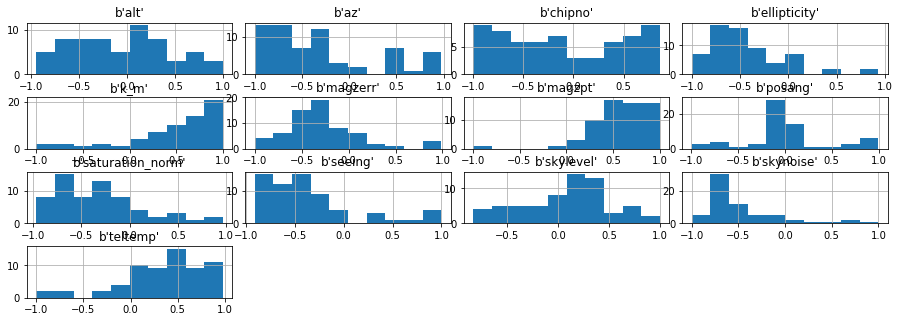

In [8]:
pd.read_pickle(train_opt.draw_dist).hist(column=[s.decode('ascii') for s in test_dataloader.dataset.data.attrs['metadata_cols']], figsize=(12, 4))
plt.tight_layout(pad=-1)
pd.DataFrame(fixed_label_noise[0].numpy(), columns=test_dataloader.dataset.data.attrs['metadata_cols']).hist(figsize=(12, 4))
plt.tight_layout(pad=-1)
plt.show()

**Model**

In [399]:
n = 1
model = train.get_model(model_opt, save_dir=None, fixed_label_noise=fixed_label_noise, n=n)

Creating model... Done.


In [400]:
unique_name = str(2004201138049147581004)
iteration = 100000
model.load(os.path.join(train_opt.save_dir, unique_name, 'model_{}.pt'.format(iteration)))

In [12]:
model.eval()

In [387]:
model.netG

ConditionalGenerator(
  (linear): Linear(in_features=13, out_features=512, bias=True)
  (model): Sequential(
    (convT0): UpsamplingLayer(
      (layer): ConvTranspose2d(640, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (batchnorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (convT1): UpsamplingLayer(
      (layer): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (convT2): UpsamplingLayer(
      (layer): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (convT3): UpsamplingLayer(
      (layer): ConvTranspose2d(256, 128, kernel_size=(4, 4),

In [388]:
summary(model.netG, [[model_opt.numeric_features], [model_opt.nz]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           7,168
   ConvTranspose2d-2            [-1, 512, 4, 4]       5,242,880
   UpsamplingLayer-3            [-1, 512, 4, 4]               0
       BatchNorm2d-4            [-1, 512, 4, 4]           1,024
              ReLU-5            [-1, 512, 4, 4]               0
   ConvTranspose2d-6            [-1, 512, 8, 8]       4,194,304
   UpsamplingLayer-7            [-1, 512, 8, 8]               0
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
              ReLU-9            [-1, 512, 8, 8]               0
  ConvTranspose2d-10          [-1, 256, 16, 16]       2,097,152
  UpsamplingLayer-11          [-1, 256, 16, 16]               0
      BatchNorm2d-12          [-1, 256, 16, 16]             512
             ReLU-13          [-1, 256, 16, 16]               0
  ConvTranspose2d-14          [-1, 128,

(tensor(12201409), tensor(12201409))

In [389]:
model.netD

MultiScalePatchDiscriminator(
  (primary_layers): ModuleDict(
    (conv0): GeneralizedSequential(
      (conv0): Conv2dPlusLinear(
        (conv): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (linear): Linear(in_features=12, out_features=256, bias=False)
        (conv11): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (leaky_relu0): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv1): Sequential(
      (conv1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (leaky_relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): Sequential(
      (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (leaky_relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv3): Sequential(
      (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (leaky_relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv4): Sequential(
    

In [390]:
summary(model.netD, np.array([[1, model_opt.size, model_opt.size], [model_opt.numeric_features-n]]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 64, 64]           6,656
            Linear-2                  [-1, 256]           3,072
            Conv2d-3          [-1, 128, 64, 64]          32,896
  Conv2dPlusLinear-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
         LeakyReLU-7          [-1, 256, 32, 32]               0
            Conv2d-8          [-1, 512, 16, 16]       2,097,664
         LeakyReLU-9          [-1, 512, 16, 16]               0
           Conv2d-10           [-1, 1024, 8, 8]       8,389,632
        LeakyReLU-11           [-1, 1024, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]      16,778,240
        LeakyReLU-13           [-1, 1024, 4, 4]               0
           Conv2d-14              [-1, 

(tensor(27865474), tensor(27865474))

In [43]:
plt.style.use('default')

**Losses (from model, not tensorboard)**

In [168]:
from tensorboard.backend.event_processing import event_accumulator

In [421]:
ea1 = event_accumulator.EventAccumulator(os.path.join(train_opt.save_dir, unique_name, 'events.out.tfevents.1587379085.cpu-e-296.350391.0'),
                                        size_guidance={event_accumulator.IMAGES: 1000,
                                                       event_accumulator.SCALARS: 60000,
                                                       event_accumulator.HISTOGRAMS: 1000})
ea2 = event_accumulator.EventAccumulator(os.path.join(train_opt.save_dir, unique_name, 'events.out.tfevents.1587887797.cpu-e-482.322377.1'),
                                        size_guidance={event_accumulator.IMAGES: 1000,
                                                       event_accumulator.SCALARS: 60000,
                                                       event_accumulator.HISTOGRAMS: 1000})
ea1.Reload()
ea2.Reload()

In [439]:
ea1.Tags(), ea2.Tags()

({'images': ['images'],
  'audio': [],
  'histograms': ['test/pred_diffs', 'test/gen_diffs'],
  'scalars': ['loss/lossD_GAN',
   'loss/lossD_L',
   'loss/lossG_GAN',
   'loss/lossG_L',
   'pred/D_x_',
   'pred/D_G_z1__',
   'pred/D_G_z2__',
   'test/l1_loss'],
  'distributions': ['test/pred_diffs', 'test/gen_diffs'],
  'tensors': [],
  'graph': True,
  'meta_graph': False,
  'run_metadata': ['step1']},
 {'images': ['images'],
  'audio': [],
  'histograms': ['test/pred_diffs', 'test/gen_diffs'],
  'scalars': ['loss/lossD_GAN',
   'loss/lossD_L',
   'loss/lossG_GAN',
   'loss/lossG_L',
   'pred/D_x_',
   'pred/D_G_z1__',
   'pred/D_G_z2__',
   'test/l1_loss'],
  'distributions': ['test/pred_diffs', 'test/gen_diffs'],
  'tensors': [],
  'graph': False,
  'meta_graph': False,
  'run_metadata': []})

In [587]:
df1 = pd.DataFrame(ea1.Scalars('loss/lossG_GAN') + ea2.Scalars('loss/lossG_GAN'))
print(df1.shape)
df1[df1.step == 6]

(103764, 3)


,wall_time,step,value
5,1.587379e+09,6,0.694822


In [589]:
df1.value.mean()

0.6933744119593055

In [416]:
print()

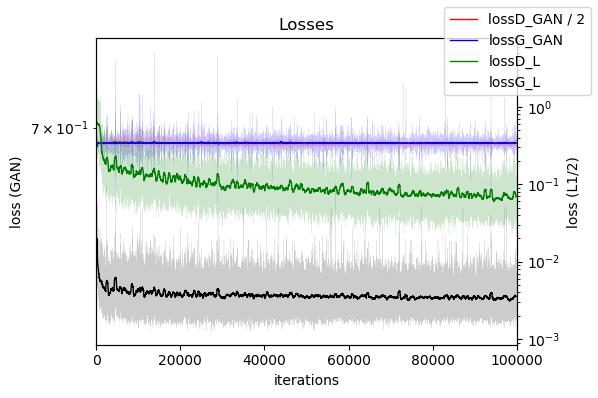

In [436]:
losses = ['loss/lossD_GAN', 'loss/lossD_L', 'loss/lossG_GAN', 'loss/lossG_L']
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

roll = 512
q = 0.9999
max_GAN, max_L = 0, 0
colors = ['r', 'g', 'b', 'k']
for i, col in enumerate(losses):
    df1 = pd.DataFrame(ea1.Scalars(col))
    df1 = df1[df1.step <= 50000]
    df2 = pd.DataFrame(ea2.Scalars(col))
    df = pd.concat([df1, df2])
    
    if col[-1:] == 'L':
        ax = ax2
        max_L = max(max_L, df.value.quantile(q)*1.1)
    elif col[-1:] in ['N', 'D']:
        ax = ax1
        max_GAN = max(max_GAN, 2 * df.value.quantile(q)*1.1)
    else:
        raise Exception
    
    label = col[5:]
    if label == 'lossD_GAN':
        label = label + ' / 2'
        df.value = df.value / 2
    
    ax.plot(df.step, df.value.to_numpy(), label=None, lw=0.2, c=colors[i%len(colors)], alpha=0.2)
    rolling = df.value.rolling(roll).mean()
    ax.plot(df.step-roll//2, rolling, label=label, lw=1, c=colors[i%len(colors)])

plt.title('Losses')
ax1.set_xlabel("iterations")
ax1.set_ylabel("loss (GAN)")
ax2.set_ylabel("loss (L1/2)")
ax1.set_xlim([0, 100100])
ax1.set_yscale('log')
ax2.set_yscale('log')
# ax1.set_ylim([0, max_GAN])
# ax2.set_ylim([0, max_L])

fig.legend()
fig.tight_layout()
plt.savefig('./imgs/train_loss.png', dpi=300)
plt.show()

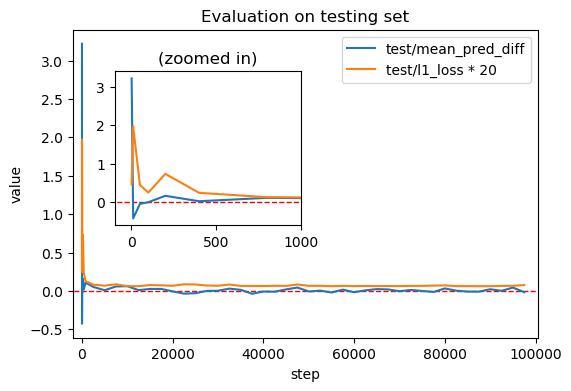

In [469]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

iax = inset_axes(ax, width='40%', height='50%', loc=2, borderpad=3)

ax.plot([-5000, 100500], [0, 0], c='r', ls='--', lw=1)
iax.plot([-5000, 100500], [0, 0], c='r', ls='--', lw=1)

df1 = pd.DataFrame(ea1.Histograms('test/pred_diffs'))
df1 = df1[df1.step <= 50000]
df2 = pd.DataFrame(ea2.Histograms('test/pred_diffs'))
df = pd.concat([df1, df2])
df['mean_diff'] = df.histogram_value.apply(lambda hist: hist.sum / hist.num)
ax.plot(df.step, df.mean_diff, label='test/mean_pred_diff')
iax.plot(df.step, df.mean_diff, label=None)

df1 = pd.DataFrame(ea1.Scalars('test/l1_loss'))
df1 = df1[df1.step <= 50000]
df2 = pd.DataFrame(ea2.Scalars('test/l1_loss'))
df = pd.concat([df1, df2])
ax.plot(df.step, df.value*20, label='test/l1_loss * 20')
iax.plot(df.step, df.value*20, label=None)

ax.set_title('Evaluation on testing set')
iax.set_title('(zoomed in)')
ax.set_xlabel('step')
ax.set_ylabel('value')
ax.set_xlim([-2000, 100500])
iax.set_xlim([-100, 1000])
ax.legend()
# fig.tight_layout()
fig.savefig('./imgs/test_loss.png', dpi=300)
plt.show()

In [482]:
col = 'loss/lossD_L'
df1 = pd.DataFrame(ea1.Scalars(col))
df1 = df1[df1.step <= 50000]
df2 = pd.DataFrame(ea2.Scalars(col))
df = pd.concat([df1, df2])
df.step.max()

99996

In [486]:
print(df1[df1.step == df1.step.min()])
print(df1[df1.step == df1.step.max()])
print(df2[df2.step == df2.step.min()])
print(df2[df2.step == df2.step.max()])

      wall_time  step     value
0  1.587379e+09     1  1.429115
          wall_time   step    value
49999  1.587419e+09  50000  0.06765
      wall_time   step     value
0  1.587888e+09  50001  0.057729
          wall_time   step     value
49995  1.587927e+09  99996  0.078794


In [493]:
t1 = df1[df1.step == df1.step.max()].wall_time.to_numpy() - df1[df1.step == df1.step.min()].wall_time.to_numpy()
t1

array([40072.40468001])

In [494]:
t2 = df2[df2.step == df2.step.max()].wall_time.to_numpy() - df2[df2.step == df2.step.min()].wall_time.to_numpy()
t2

array([39238.46703029])

In [498]:
(t1 + t2) / 60 / 60

array([22.0307977])

**losses stored in model**

In [ ]:
losses = pd.DataFrame(model.losses, columns=model.loss_tensors)  # pandas Series have .rolling function
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

roll = 128
q = 0.99
max_GAN, max_L = 0, 0
colors = ['r', 'g', 'b', 'k']
for i, col in enumerate(losses):
    if col[-1:] == 'L':
        ax = ax2
        max_L = max(max_L, losses[col].quantile(q)*1.1)
    elif col[-1:] in ['N', 'D']:
        ax = ax1
        max_GAN = max(max_GAN, losses[col].quantile(q)*1.1)
    else:
        raise Exception
    
    rolling = losses[col].rolling(roll).mean()
    ax.plot(losses[col].to_numpy(), label=None, lw=0.2, c=colors[i%len(colors)], alpha=0.2)
    ax.plot(losses.index-roll//2, rolling, label=col, lw=1, c=colors[i%len(colors)])

plt.title('Losses')
ax1.set_xlabel("iterations")
ax1.set_ylabel("loss (GAN)")
ax2.set_ylabel("loss (L1/2)")
ax1.set_xlim([0, losses.index.max()*1.01])
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_ylim([0, max_GAN])
ax2.set_ylim([0, max_L])

fig.legend()
fig.tight_layout()
plt.show()

In [ ]:
losses = pd.DataFrame(model.losses, columns=model.loss_tensors)  # pandas Series have .rolling function
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

roll = 128
q = 0.99
max_GAN, max_L = 0, 0
colors = ['r', 'g', 'b', 'k']
for i, col in enumerate(losses):
    if col[-1:] == 'L':
        ax = ax2
        max_L = max(max_L, losses[col].quantile(q)*1.1)
    elif col[-1:] in ['N', 'D']:
        ax = ax1
        max_GAN = max(max_GAN, losses[col].quantile(q)*1.1)
    else:
        raise Exception
    
    rolling = losses[col].rolling(roll).mean()
    ax.plot(losses[col].to_numpy(), label=None, lw=0.2, c=colors[i%len(colors)], alpha=0.2)
    ax.plot(losses.index-roll//2, rolling, label=col, lw=1, c=colors[i%len(colors)])

plt.title('Losses')
ax1.set_xlabel("iterations")
ax1.set_ylabel("loss (GAN)")
ax2.set_ylabel("loss (L1/2)")
ax1.set_xlim([0, losses.index.max()*1.01])
# ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim([0, max_GAN])
ax2.set_ylim([0.003, max_L])

fig.legend()
fig.tight_layout()
plt.show()

In [ ]:
preds = pd.DataFrame(model.preds, columns=['D(x)', 'D(G(z1))', 'D(G(z2))'])
fig, ax = plt.subplots(figsize=(6, 4))

roll = 128
q = 0.99
max_GAN, max_L = 0, 0
colors = ['r', 'g', 'b', 'k']
for i, col in enumerate(preds):
    rolling = preds[col].rolling(roll).mean()
    ax.plot(preds[col].to_numpy(), label=None, lw=0.2, c=colors[i%len(colors)], alpha=0.2)
    ax.plot(preds.index-roll//2, rolling, label=col, lw=1, c=colors[i%len(colors)])

plt.title('Predictions')
ax.set_xlabel("iterations")
ax.set_ylabel("predictions")
ax.set_xlim([0, preds.index.max()*1.01])
ax.set_ylim([0.5, 0.65])

fig.legend()
fig.tight_layout()
plt.show()

**Generate images**

In [474]:
real_batch = next(iter(test_dataloader))

In [475]:
# Grab a batch of real images from the dataloader
real_image = real_batch[0][:24]
real_label = real_batch[1][:24]
real_noise = real_batch[2][:24]

# fake_in = torch.randn(opt.batch_size, opt.input_nc, opt.size, opt.size, device='cpu')
# fake_in = torch.cat([fake_in, real_labels], dim=1)
fake_image = model.generate_images(real_label, real_noise)

# sort_order = real_labels[0][:, 0].argsort()
sort_order = real_label[:, 0].argsort()
real_image = real_image[sort_order]
fake_image = fake_image[sort_order]

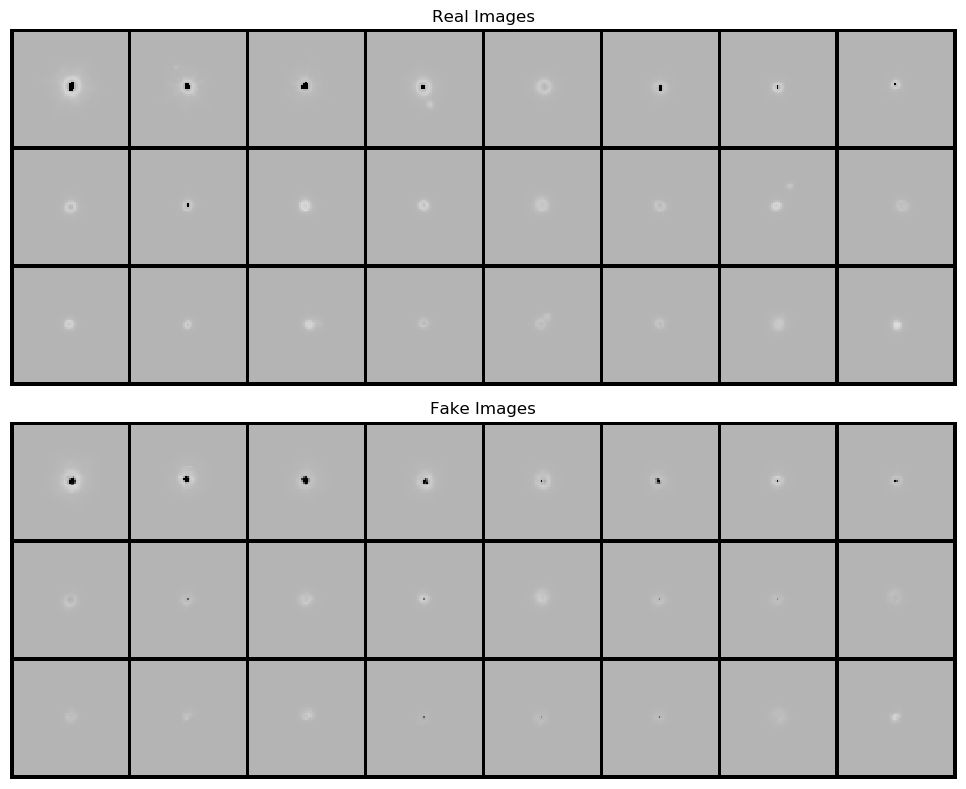

In [476]:
plt.figure(figsize=(16, 8))

# Plot the real images
plt.subplot(2, 1, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(make_grid_transpose(real_image, range=(-1, 1)))
plt.xticks([])
plt.yticks([])

# Generate and plot the corresponding fake images
plt.subplot(2, 1, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid_transpose(fake_image, range=(-1, 1)))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

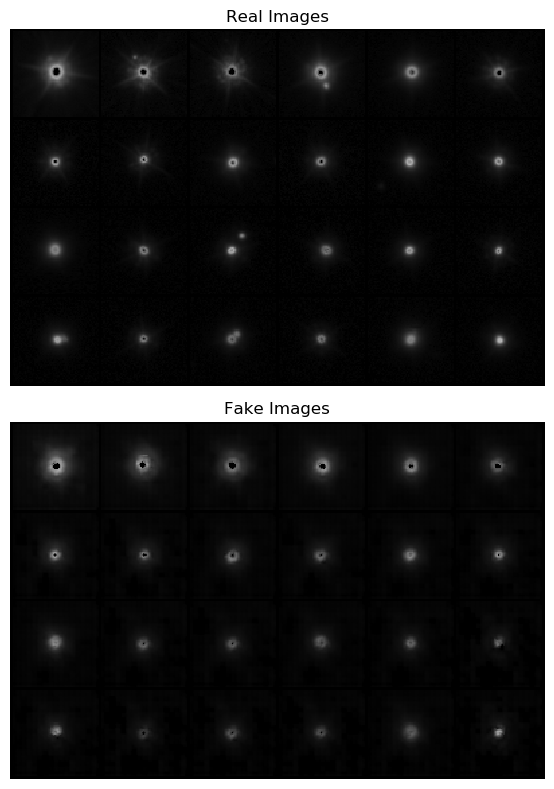

In [477]:
plt.figure(figsize=(6, 8))

# Plot the real images
plt.subplot(2, 1, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(make_grid_transpose(real_image, nrow=6))
plt.xticks([])
plt.yticks([])

# Generate and plot the corresponding fake images
plt.subplot(2, 1, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid_transpose(fake_image, nrow=6))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('./imgs/gen3.png', dpi=300, transparent=True)
plt.show()

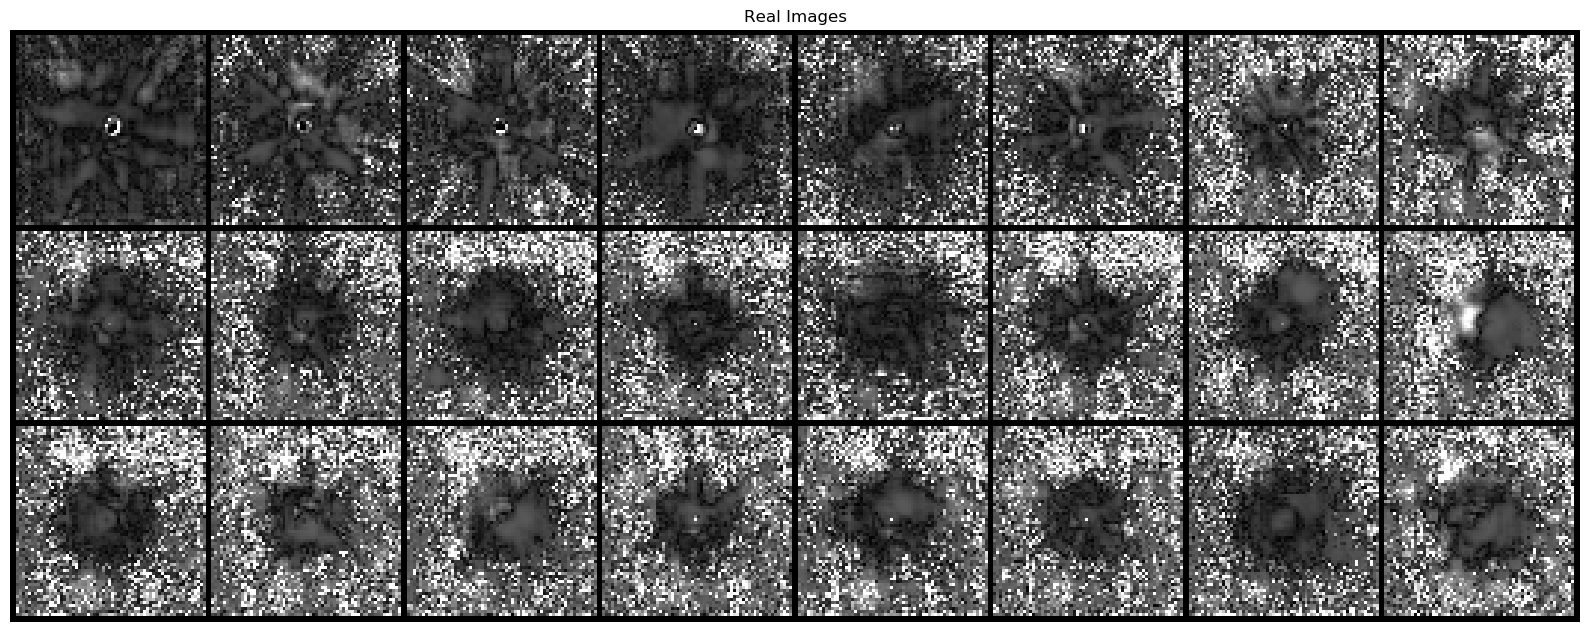

In [478]:
plt.figure(figsize=(16, 8))

# Plot the real images
plt.axis("off")
plt.title("Real Images")
plt.imshow(make_grid_transpose(np.abs((real_image-fake_image)/real_image), range=(0, 8)))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

**Evolution (from model, not tensorboard)**

In [234]:
import tensorflow as tf
sess = tf.InteractiveSession()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [500]:
encoded_imgs1 = ea1.Images('images')
encoded_imgs2 = ea2.Images('images')

In [501]:
from collections import OrderedDict
img_list = OrderedDict()
for ievent in encoded_imgs1:
    if ievent.step > 50000:
        continue
    img_list[ievent.step] = tf.io.decode_image(ievent.encoded_image_string, dtype=tf.float32).eval()[:, :, 0]

for ievent in encoded_imgs2:
    img_list[ievent.step] = tf.io.decode_image(ievent.encoded_image_string, dtype=tf.float32).eval()[:, :, 0]

(array([2.5636e+05, 3.7870e+03, 1.3920e+03, 2.1200e+02, 3.8000e+01,
        4.0000e+01, 6.0000e+01, 6.5000e+01, 6.2000e+01, 1.2800e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

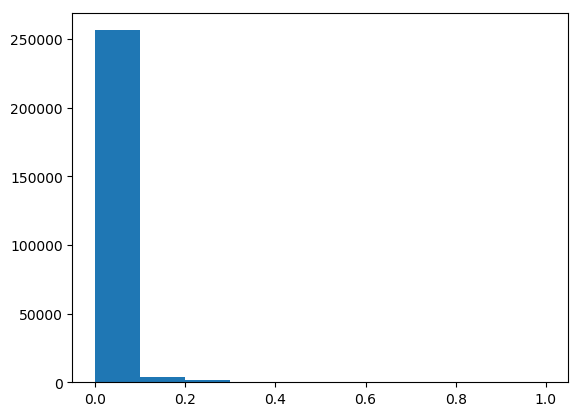

In [502]:
plt.hist(img_list[5000].flatten())

In [503]:
img_list[5000].shape

(512, 512)

In [504]:
def blockshaped(arr, nrows=64, ncols=64):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

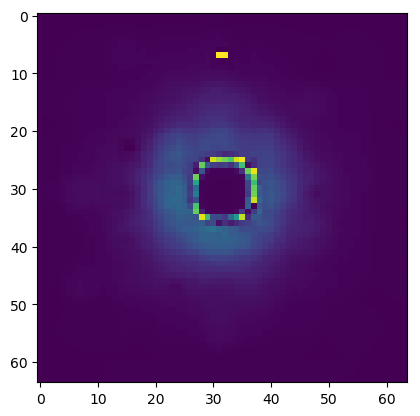

In [505]:
plt.imshow(blockshaped(img_list[5000])[0])

In [506]:
torch.cat([torch.FloatTensor(img).unsqueeze(0).unsqueeze(1) for img in img_list.values()], dim=0).shape

torch.Size([46, 1, 512, 512])

In [507]:
len(model.img_list)

0

In [ ]:
# imgs = np.concatenate([np.transpose(make_grid_transpose(imgs)[:, :opt.size+2], (1, 0, 2)) for imgs in model.img_list.values()], axis=0)
imgs = np.concatenate([make_grid_transpose(imgs[::9])[:-2] for imgs in model.img_list.values()], axis=0)
print(imgs.shape)

plt.figure(figsize=(8, 24))
plt.imshow(imgs)
plt.title('model.netG(fixed_input) at different iterations')  #, with mean L1_loss in brackets')
plt.xticks([])

labels = []
iters = list(model.img_list.keys())
losses = pd.DataFrame(model.losses, columns=model.loss_tensors)
for i in range(len(iters)):
    if i == 0:
        meanL1 = losses.lossG_L[:iters[i]].mean()
    else:
        meanL1 = losses.lossG_L[iters[i-1]:iters[i]].mean()
    labels.append(str(iters[i]))  # '{} ({:.3g})'.format(iters[i], meanL1))
plt.yticks(np.arange(len(model.img_list))*(model_opt.size+2)+(model_opt.size//2+1), labels=labels, rotation=-90, va='center')

plt.tight_layout()
plt.show()

In [583]:
selection = list(range(1, 3)) + list(range(4, 8)) + [9] + list(range(len(img_list)-1, 10, -8))[::-1]
len(selection), selection

(12, [1, 2, 4, 5, 6, 7, 9, 13, 21, 29, 37, 45])

In [584]:
np.array(list(img_list.keys()))[selection]

array([   10,    50,   200,   400,   800,  2500,  7500, 17500, 37500,
       57500, 77500, 97500])

torch.Size([794, 530, 3])


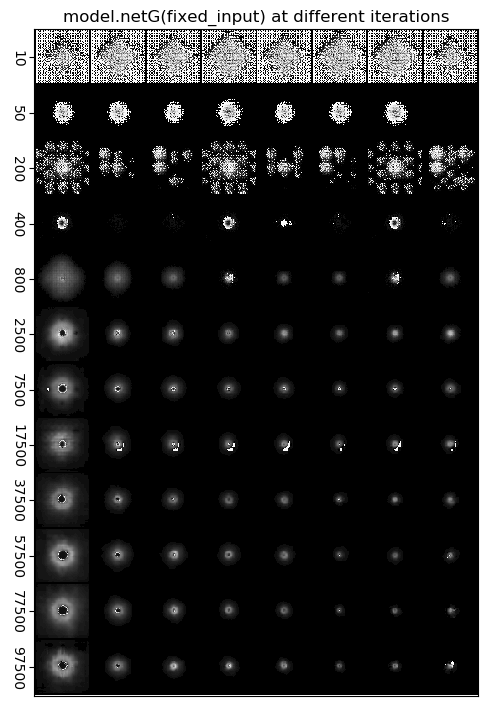

In [586]:
imgs = make_grid_transpose(torch.FloatTensor(np.concatenate([blockshaped(img)[::9] for i, img in enumerate(img_list.values()) if i in selection])).unsqueeze(1), nrow=8, num=1000)
print(imgs.shape)

plt.figure(figsize=(5, 7.2))
plt.imshow(imgs)
plt.title('model.netG(fixed_input) at different iterations')  #, with mean L1_loss in brackets')
plt.xticks([])
plt.yticks([])

plt.yticks(np.arange(len(selection))*(model_opt.size+2)+(model_opt.size//2+1), labels=np.array(list(img_list.keys()))[selection], rotation=-90, va='center')

plt.tight_layout()
plt.savefig('./imgs/evolution.png', dpi=300)
plt.show()

**K_m predictions**

In [590]:
fluxes = []
preds = []
print("Running (out of {}):".format(len(test_dataloader)), end=' ', flush=True)
for i, batch in enumerate(test_dataloader):
    print(i, end=' ', flush=True)
    image = batch[0]
    label = batch[1]
    fluxes.append(label[:, 0])
    pred = model.netD(image, label[:, 1:])
    preds.append(pred[:, 1].detach().numpy())
fluxes = np.concatenate(fluxes, axis=0)
preds = np.concatenate(preds, axis=0).squeeze()

Running (out of 51): 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [591]:
sort_order = fluxes.argsort()
fluxes = fluxes[sort_order]
preds = preds[sort_order]

In [592]:
k_min, k_max = test_dataloader.dataset.data.attrs['metadata_mins'][0], test_dataloader.dataset.data.attrs['metadata_maxs'][0]
k_dif = k_max - k_min

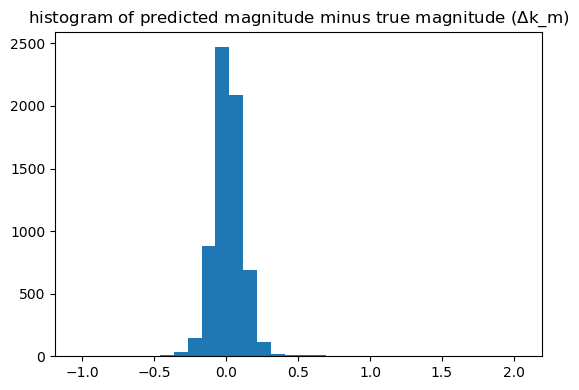

In [593]:
plt.figure(figsize=(6, 4))
plt.hist((preds - fluxes)/2*k_dif, bins=32)
# sns.kdeplot((preds - fluxes)/2*k_dif)
plt.title(r'histogram of predicted magnitude minus true magnitude ($\Delta$k_m)')
plt.tight_layout()
plt.show()

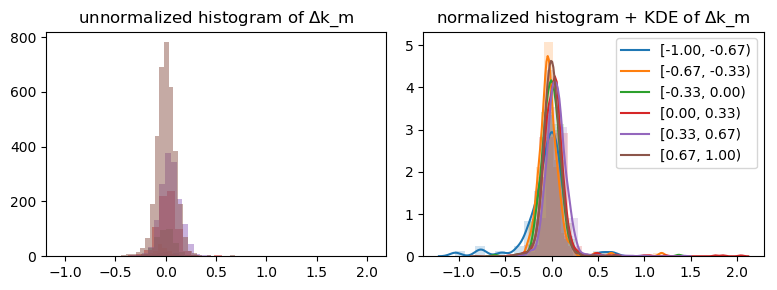

In [594]:
from itertools import cycle
import matplotlib as mpl

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
N = 6
step = 2 / N
color_cycler = cycle(plt.rcParams["axes.prop_cycle"].by_key()['color'])
means, sigmas = [], []
for i in range(N):
    color = next(color_cycler)
    a, b = fluxes.searchsorted(-1+i*step), fluxes.searchsorted(-1+(i+1)*step)
    if i == N-1:
        b = len(fluxes) + 1
    diffs = (preds - fluxes)[a:b]*k_dif/2
    means.append(diffs.mean())
    sigmas.append(diffs.std())
    ax1.hist(diffs, bins=32, alpha=0.5, density=False, color=color)
    ax2.hist(diffs, bins=16, alpha=0.2, density=True, color=color)
    sns.kdeplot(diffs, color=color, label='[{:.2f}, {:.2f})'.format(-1+i*step, -1+(i+1)*step), ax=ax2)
ax1.set_title(r'unnormalized histogram of $\Delta$k_m')
ax2.set_title(r'normalized histogram + KDE of $\Delta$k_m')

ax2.legend()
plt.tight_layout()
plt.savefig('./imgs/pred_hist.png', dpi=300)
plt.show()

In [40]:
mpl.rcParams["savefig.dpi"]

'figure'

In [595]:
list(zip(means, sigmas))

[(-0.055979922, 0.22891024),
 (-0.02128461, 0.1460741),
 (-0.0041662916, 0.12541799),
 (0.030249914, 0.17638358),
 (0.052948512, 0.12098623),
 (0.003195406, 0.098968744)]

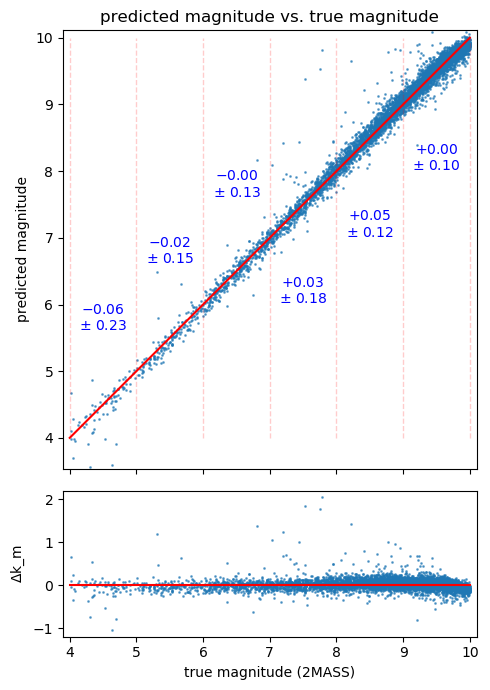

In [596]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(5, 7), gridspec_kw={'height_ratios': [3, 1]})

ax1.scatter((fluxes+1)/2*k_dif + k_min, (preds+1)/2*k_dif + k_min, alpha=0.6, s=1)
# plt.hexbin((fluxes+1)/2*k_dif + k_min, (preds+1)/2*k_dif + k_min)
ax1.plot([k_min, k_max], [k_min, k_max], c='r')
step = k_dif / N
for i, k in enumerate(np.linspace(k_min, k_max, N+1)):
    if i < N:
        ax1.text(k + step/2, k + step * (1.8 if i < N/2 else -.8),
                 r'${}{:.2f}$' '\n' r'$\pm$ {:.2f}'.format('+' if np.sign(means[i]) > 0 else '-', np.abs(means[i]), sigmas[i]),
                 ha='center', va='center', color='b')
    ax1.plot([k, k], [k_min, k_max], c='r', alpha=0.2, lw=1, ls='--')
ax1.set_title('predicted magnitude vs. true magnitude')
# ax1.set_xlabel('true magnitude (2MASS)')
ax1.set_ylabel('predicted magnitude')
ax1.axis('equal')

ax2.scatter((fluxes+1)/2*k_dif + k_min, (preds - fluxes)/2*k_dif, alpha=0.6, s=1)
ax2.plot([k_min, k_max], [0, 0], c='r')
# ax2.set_title(r'$\Delta$k_m vs. true k_m')
ax2.set_xlabel('true magnitude (2MASS)')
ax2.set_ylabel(r'$\Delta$k_m')
ax2.set_xlim([k_min-0.1, k_max+0.1])

plt.tight_layout()
plt.savefig('./imgs/pred_mag.png', dpi=300)
plt.show()

In [72]:
len(test_dataloader.dataset)

6502

**Linear Weights**

In [560]:
ss = [s.decode('ascii') for s in test_dataloader.dataset.data.attrs['metadata_cols']]
ss = [s if s != 'saturation_norm' else 'saturation' for s in ss]

In [561]:
metadata = pd.read_pickle(train_opt.draw_dist)
metadata.abs().mean()

k_m                0.646442
skylevel           0.360424
skynoise           0.561982
saturation_norm    0.510249
magzpt             0.532184
magzerr            0.402045
seeing             0.504776
ellipticity        0.516146
posang             0.279025
az                 0.595303
alt                0.476952
teltemp            0.457179
chipno             0.530833
dtype: float32

In [562]:
paramsG = dict(model.netG.named_parameters())

In [563]:
paramsG.keys()

dict_keys(['linear.weight', 'linear.bias', 'model.convT0.layer.weight', 'model.batchnorm0.weight', 'model.batchnorm0.bias', 'model.convT1.layer.weight', 'model.batchnorm1.weight', 'model.batchnorm1.bias', 'model.convT2.layer.weight', 'model.batchnorm2.weight', 'model.batchnorm2.bias', 'model.convT3.layer.weight', 'model.batchnorm3.weight', 'model.batchnorm3.bias', 'model.convT4.layer.weight', 'model.batchnorm4.weight', 'model.batchnorm4.bias', 'model.conv5.weight', 'model.conv5.bias'])

In [564]:
paramsG['linear.weight'].data.shape

torch.Size([512, 13])

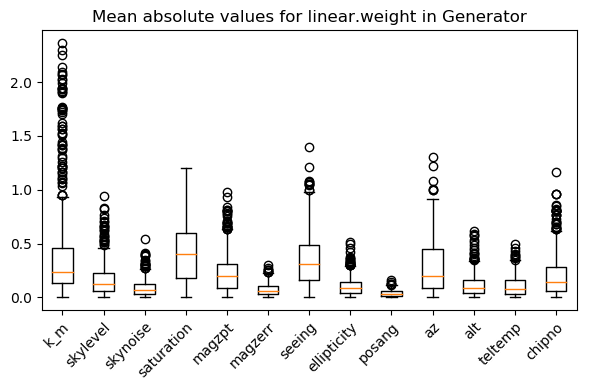

In [565]:
plt.figure(figsize=(6, 4))
plt.boxplot(paramsG['linear.weight'].data.abs().T, labels=ss)
plt.title('Mean absolute values for linear.weight in Generator')
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('./imgs/weight_gen.eps')
plt.savefig('./imgs/weight_gen.png', dpi=300)
plt.show()

<BarContainer object of 512 artists>

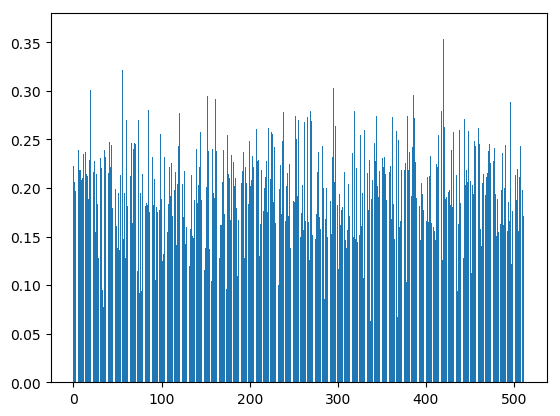

In [566]:
plt.bar(range(512), paramsG['linear.weight'].data.abs().T.mean(dim=0), label='mean')

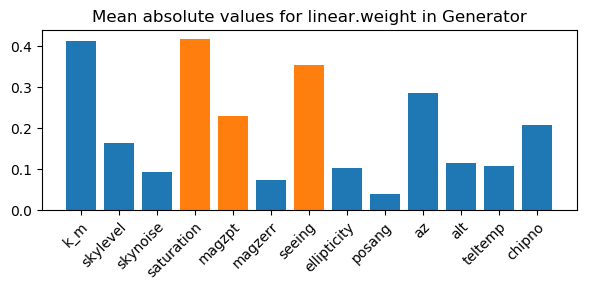

In [567]:
plt.figure(figsize=(6, 3))
# plt.bar(ss, np.quantile(paramsG['linear.weight'].data.abs().detach().numpy(), q=.75, axis=0), label='.75 quantile')
plt.bar(ss, paramsG['linear.weight'].data.abs().mean(dim=0), label='mean')
plt.bar([ss[i] for i in [3, 4, 6]], paramsG['linear.weight'].data.abs().mean(dim=0)[[3, 4, 6]], label='mean')
# plt.bar(ss, paramsG['linear.weight'].data.abs().median(dim=0)[0], label='median')
plt.title('Mean absolute values for linear.weight in Generator')
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor')
# plt.legend()
plt.tight_layout()
plt.savefig('./imgs/weight_gen_selected.png', dpi=300)
plt.show()

(array([ 4.,  7., 12., 10.,  8., 17., 12.,  8.,  9., 26., 22., 26., 19.,
        13., 20., 19., 12., 20., 19., 25., 14., 19., 23., 20., 21., 23.,
        26., 18., 19.,  8.,  7.,  6.]),
 array([-0.9374692 , -0.8796313 , -0.8217933 , -0.7639554 , -0.70611745,
        -0.64827955, -0.5904416 , -0.5326037 , -0.47476575, -0.4169278 ,
        -0.35908988, -0.30125195, -0.24341403, -0.1855761 , -0.12773818,
        -0.06990024, -0.01206231,  0.04577562,  0.10361355,  0.16145147,
         0.2192894 ,  0.27712733,  0.33496526,  0.3928032 ,  0.45064113,
         0.50847906,  0.56631696,  0.6241549 ,  0.6819928 ,  0.7398308 ,
         0.7976687 ,  0.85550666,  0.91334456], dtype=float32),
 <a list of 32 Patch objects>)

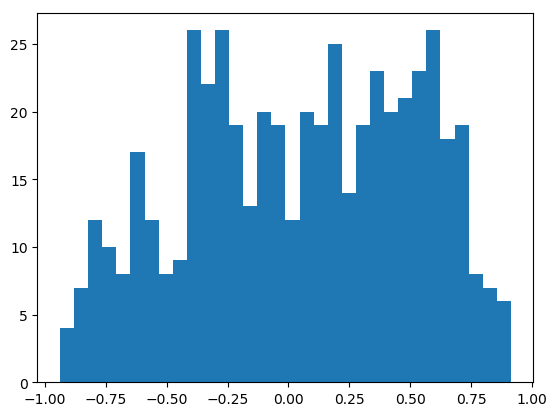

In [568]:
plt.hist(paramsG['linear.bias'].data, bins=32)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

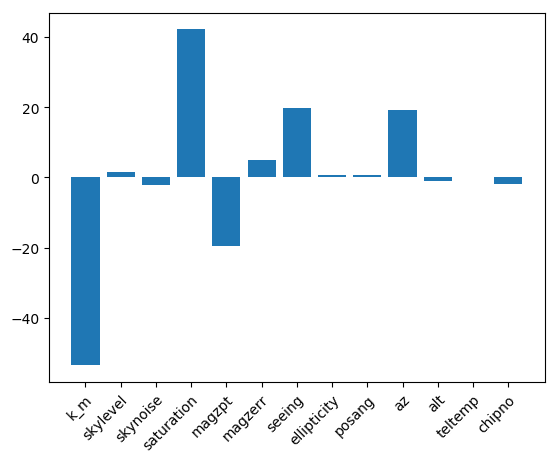

In [569]:
plt.bar(ss, np.matmul(paramsG['linear.weight'].data.T, paramsG['linear.bias'].data))
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor')

In [570]:
paramsD = dict(model.netD.named_parameters())

In [571]:
paramsD.keys()

dict_keys(['primary_layers.conv0.conv0.conv.bias', 'primary_layers.conv0.conv0.conv.weight_orig', 'primary_layers.conv0.conv0.linear.weight_orig', 'primary_layers.conv0.conv0.conv11.bias', 'primary_layers.conv0.conv0.conv11.weight_orig', 'primary_layers.conv1.conv1.bias', 'primary_layers.conv1.conv1.weight_orig', 'primary_layers.conv2.conv2.bias', 'primary_layers.conv2.conv2.weight_orig', 'primary_layers.conv3.conv3.bias', 'primary_layers.conv3.conv3.weight_orig', 'primary_layers.conv4.conv4.bias', 'primary_layers.conv4.conv4.weight_orig', 'prediction_layers.pred4.bias', 'prediction_layers.pred4.weight_orig'])

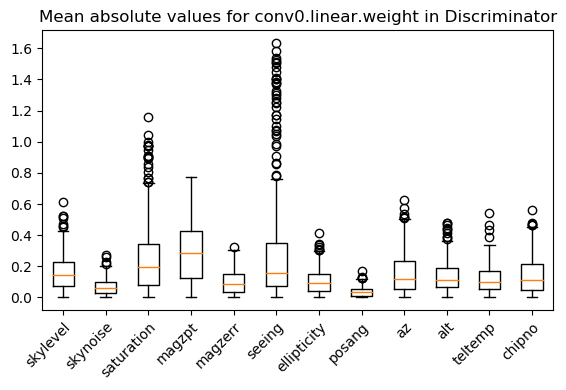

In [572]:
plt.figure(figsize=(6, 4))
plt.boxplot(paramsD['primary_layers.conv0.conv0.linear.weight_orig'].data.abs().T, labels=ss[n:])
plt.title('Mean absolute values for conv0.linear.weight in Discriminator')
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('./imgs/weight_dis.eps')
plt.savefig('./imgs/weight_dis.png', dpi=300)
plt.show()

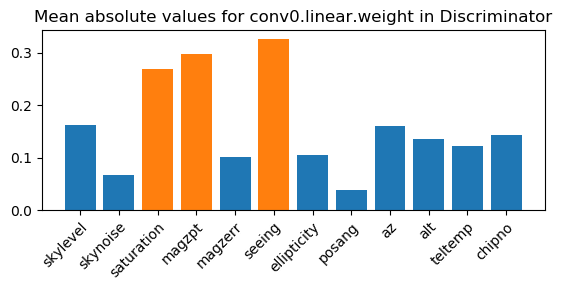

In [573]:
plt.figure(figsize=(6, 3))
plt.bar(ss[n:], paramsD['primary_layers.conv0.conv0.linear.weight_orig'].data.abs().mean(dim=0))
plt.bar([ss[i] for i in [3, 4, 6]], paramsD['primary_layers.conv0.conv0.linear.weight_orig'].data.abs().mean(dim=0)[[i-n for i in [3, 4, 6]]])
plt.title('Mean absolute values for conv0.linear.weight in Discriminator')
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor')
plt.tight_layout()
plt.savefig('./imgs/weight_dis_selected.png', dpi=300)
plt.show()

**Varying Metadata**

In [574]:
from collections import OrderedDict
x = np.linspace(-1, 1, 128)
metadata = pd.read_pickle(train_opt.draw_dist)
most_likely = OrderedDict()
for col in range(model_opt.numeric_features):
    col_name = test_dataloader.dataset.data.attrs['metadata_cols'][col].decode('ascii')
    kernel = stats.gaussian_kde(metadata[col_name])
    if col_name == 'saturation_norm':
        col_name = 'saturation'
    most_likely[col_name] = x[kernel.pdf(x).argmax()]

In [575]:
for k, v in most_likely.items():
    print('\({}\) & {:.10f} \\\\'.format(k, v))

\(k_m\) & 0.9212598425 \\
\(skylevel\) & 0.1181102362 \\
\(skynoise\) & -0.6692913386 \\
\(saturation\) & -0.6850393701 \\
\(magzpt\) & 0.4330708661 \\
\(magzerr\) & -0.3228346457 \\
\(seeing\) & -0.6062992126 \\
\(ellipticity\) & -0.5748031496 \\
\(posang\) & -0.0078740157 \\
\(az\) & -0.7952755906 \\
\(alt\) & -0.7007874016 \\
\(teltemp\) & 0.5118110236 \\
\(chipno\) & 0.6062992126 \\


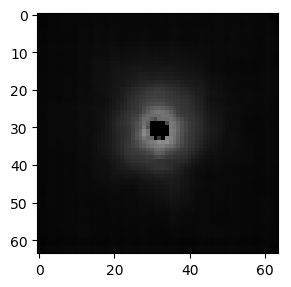

In [576]:
likiest_in = torch.FloatTensor(list(most_likely.values())).unsqueeze(0)
likiest_in[0, 0] = 0.
likiest_in[0, 12] = 0.6
fixed_noise = torch.rand(1, model_opt.nz)*2-1
image = model.generate_images(likiest_in, fixed_noise)

plt.figure(figsize=(3, 3))
plt.imshow(make_grid_transpose(image))
plt.tight_layout()
plt.show()

In [577]:
N = 8
controlled_in = likiest_in.expand(13*N, -1).clone()
controlled_noise = fixed_noise.expand(13*N, -1)
for i in range(N):
    controlled_in[i*N:(i+1)*N, i] = torch.linspace(-1, 1, N)
controlled_in.shape, controlled_noise.shape

(torch.Size([104, 13]), torch.Size([104, 128]))

In [578]:
images = model.generate_images(controlled_in, controlled_noise)

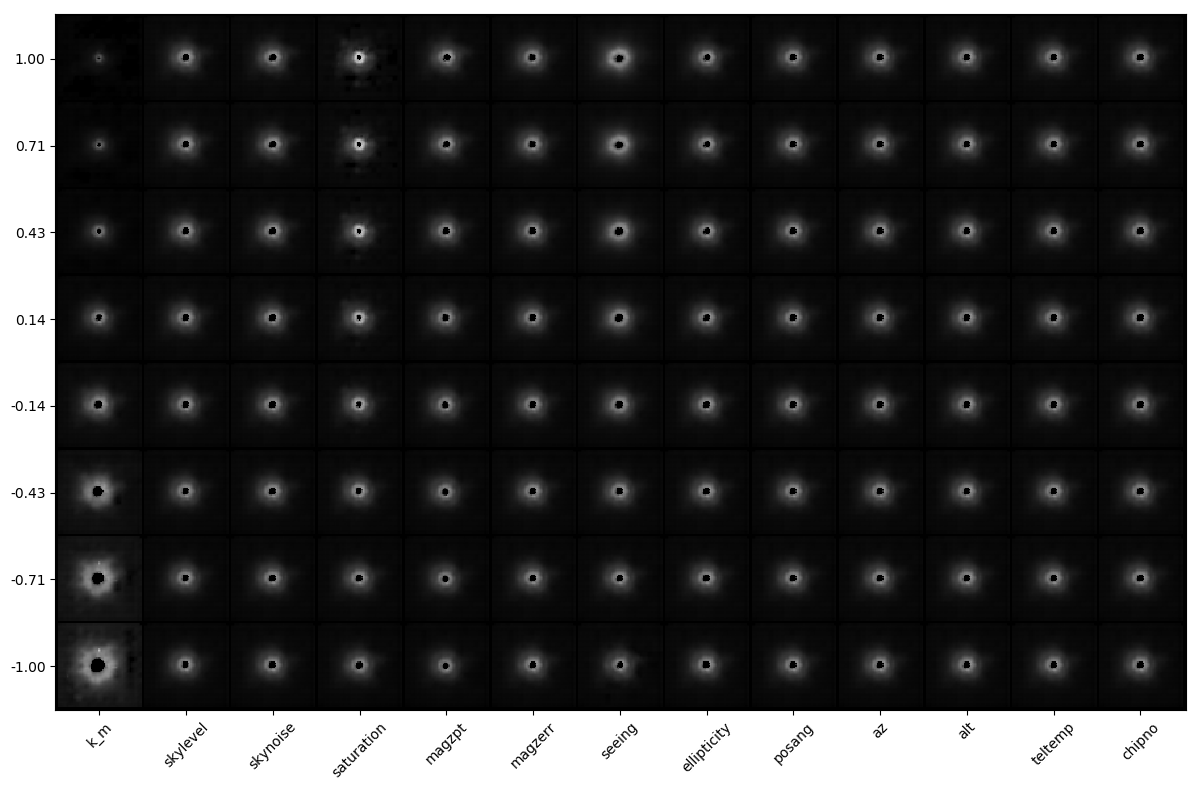

In [579]:
plt.figure(figsize=(16, 8))
plt.imshow(np.transpose(make_grid_transpose(images, num=100000), (1, 0, 2)), origin='lower')
plt.xticks(np.arange(model_opt.numeric_features)*(model_opt.size+2)+(model_opt.size//2+1), labels=most_likely.keys(), ha='center', rotation=45)
plt.yticks(np.arange(N)*(model_opt.size+2)+(model_opt.size//2+1), labels=['{:.2f}'.format(x) for x in np.linspace(-1, 1, N)])
plt.tight_layout()
plt.show()

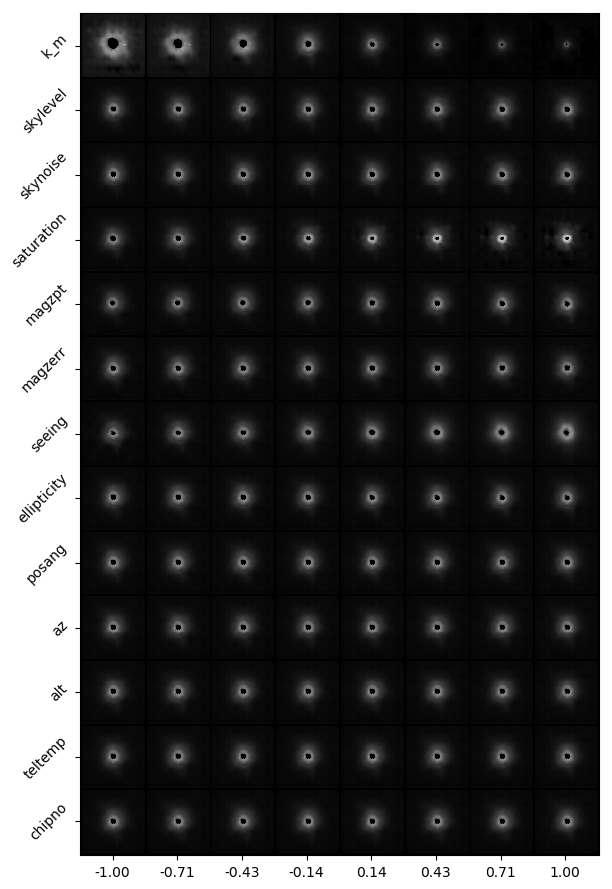

In [580]:
plt.figure(figsize=(6, 9))
plt.imshow(make_grid_transpose(images, num=100000), origin='upper')
plt.yticks(np.arange(model_opt.numeric_features)*(model_opt.size+2)+(model_opt.size//2+1), labels=most_likely.keys(), va='center', rotation=45)
plt.xticks(np.arange(N)*(model_opt.size+2)+(model_opt.size//2+1), labels=['{:.2f}'.format(x) for x in np.linspace(-1, 1, N)])
plt.tight_layout()
plt.savefig('./imgs/varying_metadata.png', dpi=300)
plt.show()

In [581]:
select = list(range(3*N, 5*N)) + list(range(6*N, 7*N))
print(select)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55]


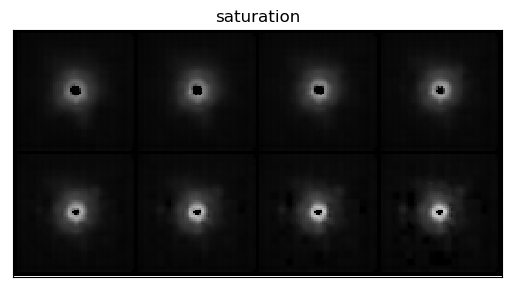

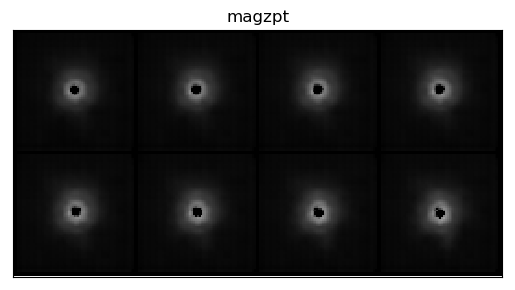

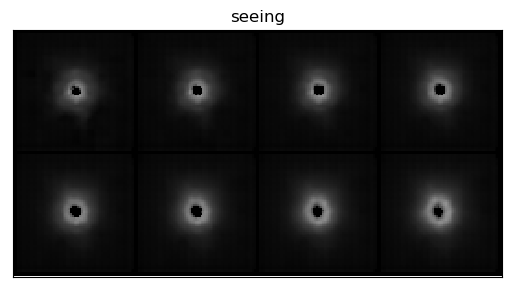

In [582]:
for x in [3, 4, 6]:
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.imshow(make_grid_transpose(images[x*N:(x+1)*N], nrow=4), origin='upper')
    ax.set_title(ss[x])
    ax.set_yticks([])
    ax.set_xticks([])

    fig.tight_layout()
    fig.savefig('./imgs/varying_{}.png'.format(ss[x]), dpi=300)
    plt.show()

In [167]:
for a, b, c in zip(train_dataloader.dataset.data.attrs['metadata_cols'],
                   train_dataloader.dataset.data.attrs['metadata_mins'],
                   train_dataloader.dataset.data.attrs['metadata_maxs']):
    print('\hline')
    print('\({}\) & {:.5g} & {:.5g} & info \\\\'.format(a.decode(), b, c))

\hline
\(k_m\) & 4.001 & 10 & info \\
\hline
\(skylevel\) & 5833.1 & 13232 & info \\
\hline
\(skynoise\) & 13.11 & 35.92 & info \\
\hline
\(saturation_norm\) & 10000 & 52058 & info \\
\hline
\(magzpt\) & 22.772 & 23.095 & info \\
\hline
\(magzerr\) & 0.01 & 0.042 & info \\
\hline
\(seeing\) & 0.51794 & 1.6628 & info \\
\hline
\(ellipticity\) & 0.029728 & 0.1619 & info \\
\hline
\(posang\) & -90.144 & -89.856 & info \\
\hline
\(az\) & 8.716 & 350.84 & info \\
\hline
\(alt\) & 34.278 & 82.546 & info \\
\hline
\(teltemp\) & 3.66 & 16.07 & info \\
\hline
\(chipno\) & 1 & 16 & info \\


In [ ]:
parD, parG = [], []
for name, param in model.netD.named_parameters():
    if name.find('batchnorm') == -1:
        parD.append(param.abs().view(-1))
for name, param in model.netG.named_parameters():
    if name.find('batchnorm') == -1:
        parG.append(param.abs().view(-1))
parD = torch.cat(parD, dim=0)
parG = torch.cat(parG, dim=0)

In [ ]:
plt.hist(parD.detach().numpy(), bins=32, log=True)
plt.show()

In [ ]:
plt.hist(parG.detach().numpy(), bins=32, log=True)
plt.show()